### Using nn Sequential

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import display,clear_output
import pandas as pd
import time
import json

from itertools import product
from collections import OrderedDict
from collections import namedtuple

import matplotlib.pyplot as plt
import math

torch.set_printoptions(linewidth=150)

In [2]:
train_set=torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        Run=namedtuple("Run",params.keys())
        
        runs=[]
        for v in product(*params.values()):
            runs.append(Run(*v))
        
        return runs

In [4]:
class RunManager():
    def __init__(self):
        self.epoch_count=0
        self.epoch_loss=0
        self.epoch_num_correct=0
        self.epoch_start_time=None
        
        self.run_params=None
        self.run_count=0
        self.run_data=[]
        self.run_start_time=None
        
        self.network=None
        self.loader=None
        self.tb=None
        
    def begin_run(self,run,network,loader):
        self.run_start_time=time.time()
        self.run_params=run
        self.run_count+=1
        
        self.network=network
        self.loader=loader
        self.tb=SummaryWriter(comment=f"-{run}")
        
        images,labels=next(iter(self.loader))
        grid=torchvision.utils.make_grid(images)
        
        self.tb.add_image("images",grid)
        self.tb.add_graph(self.network,images.to(getattr(run,'device','cpu')))
        
    def end_run(self):
        self.tb.close()
        self.epoch_count=0
        
    def begin_epoch(self):
        self.epoch_start_time=time.time()
        self.epoch_count+=1
        self.epoch_loss=0
        self.epoch_num_correct=0
        
    def end_epoch(self):
        epoch_duration=time.time()-self.epoch_start_time
        run_duration=time.time()-self.run_start_time
        
        loss=self.epoch_loss/len(self.loader.dataset)
        accuracy=self.epoch_num_correct/len(self.loader.dataset)
        
        self.tb.add_scalar("Loss",loss,self.epoch_count)
        self.tb.add_scalar("Accuracy",accuracy,self.epoch_count)
        
        for name,param in self.network.named_parameters():
            self.tb.add_histogram(name,param,self.epoch_count)
            self.tb.add_histogram(f"{name}.grad",param.grad,self.epoch_count)
        
        results=OrderedDict()
        results["run"]=self.run_count
        results["epoch"]=self.epoch_count
        results["loss"]=loss
        results["accuracy"]=accuracy
        results["epoch duration"]=epoch_duration
        results["run duration"]=run_duration
        
        for k,v in self.run_params._asdict().items(): results[k]=v
        self.run_data.append(results)
        
        df=pd.DataFrame.from_dict(self.run_data,orient="columns")
        
        clear_output(wait=True)
        display(df)
        
    def track_loss(self,loss,batch):
        self.epoch_loss+=loss.item()*batch[0].shape[0]

    def track_num_correct(self,preds,labels):
        self.epoch_num_correct+=self._get_num_correct(preds,labels)

    @torch.no_grad()
    def _get_num_correct(self,preds,labels):
        return preds.argmax(dim=1).eq(labels).sum().item()

    def save(self,filename):
        pd.DataFrame.from_dict(self.run_data,orient="columns").to_csv(f"{filename}.csv")

        with open(f"{filename}.json","w",encoding="utf-8") as f:
            json.dump(self.run_data,f,ensure_ascii=False,indent=4)
            

In [5]:
image,label=train_set[0]
image.shape

torch.Size([1, 28, 28])

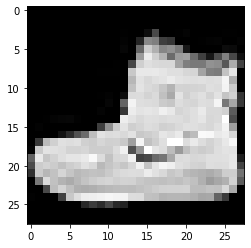

In [6]:
plt.imshow(image.squeeze(),cmap='gray')

In [7]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
in_features=image.numel()
in_features

784

In [9]:
out_features=math.floor(in_features/2)
out_features

392

In [10]:
out_classes=len(train_set.classes)
out_classes

10

#### Sequential Model Initialization: Way 1


In [11]:
network1=nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.Linear(in_features,out_features),
    nn.Linear(out_features,out_classes))

network1

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=392, bias=True)
  (2): Linear(in_features=392, out_features=10, bias=True)
)

In [12]:
network1[1]

Linear(in_features=784, out_features=392, bias=True)

In [13]:
image=image.unsqueeze(0)
image.shape

torch.Size([1, 1, 28, 28])

In [14]:
network1(image)

tensor([[ 0.3857, -0.1832,  0.2080,  0.1778,  0.1562, -0.0369, -0.2482, -0.2302,  0.0485,  0.0138]], grad_fn=<AddmmBackward>)

#### Sequential Model Initialization: Way 2

In [15]:
layers=OrderedDict([
    ('flat',nn.Flatten(start_dim=1)),
    ('hidden',nn.Linear(in_features,out_features)),
    ('output',nn.Linear(out_features,out_classes))])

network2=nn.Sequential(layers)
network2

Sequential(
  (flat): Flatten()
  (hidden): Linear(in_features=784, out_features=392, bias=True)
  (output): Linear(in_features=392, out_features=10, bias=True)
)

In [16]:
network2(image)

tensor([[-0.0645, -0.1173,  0.0658, -0.0971, -0.2111, -0.3193, -0.0889,  0.0945, -0.3315, -0.0928]], grad_fn=<AddmmBackward>)

In [17]:
torch.manual_seed(50)
network1=nn.Sequential(
    nn.Flatten(start_dim=1),
    nn.Linear(in_features,out_features),
    nn.Linear(out_features,out_classes))


In [18]:
torch.manual_seed(50)
layers=OrderedDict([
    ('flat',nn.Flatten(start_dim=1)),
    ('hidden',nn.Linear(in_features,out_features)),
    ('output',nn.Linear(out_features,out_classes))])

network2=nn.Sequential(layers)

In [19]:
network1(image),network2(image)

(tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>))

#### Sequential Model Initialization: Way 3


In [20]:
torch.manual_seed(50)
network3=nn.Sequential()
network3.add_module('flat',nn.Flatten(start_dim=1))
network3.add_module('hidden',nn.Linear(in_features,out_features))
network3.add_module('out',nn.Linear(out_features,out_classes))
network3

Sequential(
  (flat): Flatten()
  (hidden): Linear(in_features=784, out_features=392, bias=True)
  (out): Linear(in_features=392, out_features=10, bias=True)
)

In [21]:
network1(image),network2(image),network3(image)

(tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1681,  0.1028, -0.0790, -0.0659, -0.2436,  0.1328, -0.0864,  0.0016,  0.1819, -0.0168]], grad_fn=<AddmmBackward>))

#### Class Definition method

In [22]:
torch.manual_seed(50)
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,6,5)
        self.conv2=nn.Conv2d(6,12,5)
        self.fc1=nn.Linear(in_features=12*4*4,out_features=120)
        self.fc2=nn.Linear(in_features=120,out_features=60)
        self.out=nn.Linear(in_features=60,out_features=10)
    
    def forward(self,t):
        t=F.relu(self.conv1(t))
        t=F.max_pool2d(t,kernel_size=2,stride=2)
        t=F.relu(self.conv2(t))
        t=F.max_pool2d(t,kernel_size=2,stride=2)
        t=t.flatten(start_dim=1)
        t=F.relu(self.fc1(t))
        t=F.relu(self.fc2(t))
        t=self.out(t)
        
        return t

network=Network()

#### Sequential method

In [23]:
torch.manual_seed(50)
sequential1=nn.Sequential(
    nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=12*4*4,out_features=120),
    nn.ReLU(),
    nn.Linear(in_features=120,out_features=60),
    nn.ReLU(),
    nn.Linear(in_features=60,out_features=10)
)

In [24]:
torch.manual_seed(50)
layers=OrderedDict([
    ('conv1',nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)),
    ('relu1',nn.ReLU()),
    ('maxpool1',nn.MaxPool2d(kernel_size=2,stride=2)),
    
    ('conv2',nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)),
    ('relu2',nn.ReLU()),
    ('maxpool2',nn.MaxPool2d(kernel_size=2,stride=2)),
    
    ('flatten',nn.Flatten(start_dim=1)),
    ('fc1',nn.Linear(in_features=12*4*4,out_features=120)),
    ('relu3',nn.ReLU()),
    
    ('fc2',nn.Linear(in_features=120,out_features=60)),
    ('relu4',nn.ReLU()),
    ('out',nn.Linear(in_features=60,out_features=10))])

sequential2=nn.Sequential(layers)

In [25]:
torch.manual_seed(50)
sequential3=nn.Sequential()
sequential3.add_module('conv1',nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5))
sequential3.add_module('relu1',nn.ReLU())
sequential3.add_module('maxpool1',nn.MaxPool2d(kernel_size=2,stride=2))
sequential3.add_module('conv2',nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5))
sequential3.add_module('relu2',nn.ReLU())
sequential3.add_module('maxpool2',nn.MaxPool2d(kernel_size=2,stride=2))
sequential3.add_module('flatten',nn.Flatten(start_dim=1))
sequential3.add_module('fc1',nn.Linear(in_features=12*4*4,out_features=120))
sequential3.add_module('relu3',nn.ReLU())
sequential3.add_module('fc2',nn.Linear(in_features=120,out_features=60))
sequential3.add_module('relu4',nn.ReLU())
sequential3.add_module('out',nn.Linear(in_features=60,out_features=10))

In [26]:
sequential1

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=192, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=60, bias=True)
  (10): ReLU()
  (11): Linear(in_features=60, out_features=10, bias=True)
)

In [27]:
sequential2

Sequential(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (relu4): ReLU()
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [28]:
sequential3

Sequential(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (relu4): ReLU()
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [29]:
network(image),sequential1(image),sequential2(image),sequential3(image)

(tensor([[-0.0957,  0.1053, -0.1055,  0.1547, -0.0366, -0.0132,  0.0749, -0.1152,  0.0426,  0.0639]], grad_fn=<AddmmBackward>),
 tensor([[-0.0957,  0.1053, -0.1055,  0.1547, -0.0366, -0.0132,  0.0749, -0.1152,  0.0426,  0.0639]], grad_fn=<AddmmBackward>),
 tensor([[-0.0957,  0.1053, -0.1055,  0.1547, -0.0366, -0.0132,  0.0749, -0.1152,  0.0426,  0.0639]], grad_fn=<AddmmBackward>),
 tensor([[-0.0957,  0.1053, -0.1055,  0.1547, -0.0366, -0.0132,  0.0749, -0.1152,  0.0426,  0.0639]], grad_fn=<AddmmBackward>))

### Using BatchNorm

In [30]:
torch.manual_seed(50)
network1=nn.Sequential(
    nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=12*4*4,out_features=120),
    nn.ReLU(),
    nn.Linear(in_features=120,out_features=60),
    nn.ReLU(),
    nn.Linear(in_features=60,out_features=10)
)

In [31]:
torch.manual_seed(50)
network2=nn.Sequential(
    nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.BatchNorm2d(6),
    nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.BatchNorm2d(12),
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=12*4*4,out_features=120),
    nn.ReLU(),
    nn.BatchNorm1d(120),
    nn.Linear(in_features=120,out_features=60),
    nn.ReLU(),
    nn.Linear(in_features=60,out_features=10)
)

In [32]:
train_set=torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]))

In [33]:
loader=DataLoader(train_set,batch_size=len(train_set),num_workers=1)
data=next(iter(loader))
mean=data[0].mean()
std=data[0].std()
mean,std

(tensor(0.2861), tensor(0.3530))

In [34]:
train_set_normal=torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
        transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)]))

In [35]:
trainsets={
    'not normal':train_set,
    'normal':train_set_normal}

In [36]:
networks={
    'no batch_norm':network1,
    'batch_norm':network2
}

In [37]:
params=OrderedDict(
    lr=[0.01],
    batch_size=[1000],
    num_workers=[1],
    device=['cuda'],
    trainset=['not normal','normal'],
    network=list(networks.keys())
)

m=RunManager()
for run in RunBuilder.get_runs(params):
    device=torch.device(run.device)
    network=networks[run.network].to(device)
    loader=DataLoader(trainsets[run.trainset],batch_size=run.batch_size,num_workers=run.num_workers)
    optimizer=optim.Adam(network.parameters(),lr=run.lr)
    
    m.begin_run(run,network,loader)
    for epoch in range(20):
        m.begin_epoch()
        for batch in loader:
            images=batch[0].to(device)
            labels=batch[1].to(device)
            preds=network(images)
            loss=F.cross_entropy(preds,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            m.track_loss(loss,batch)
            m.track_num_correct(preds,labels)
        m.end_epoch()
    m.end_run()
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset,network
0,1,1,1.009760,0.607567,7.102051,8.440114,0.01,1000,1,cuda,not normal,no batch_norm
1,1,2,0.543566,0.789683,6.931353,15.534446,0.01,1000,1,cuda,not normal,no batch_norm
2,1,3,0.459305,0.830867,6.912772,22.549157,0.01,1000,1,cuda,not normal,no batch_norm
3,1,4,0.407676,0.850650,7.060338,29.757443,0.01,1000,1,cuda,not normal,no batch_norm
4,1,5,0.372141,0.863483,7.147327,37.011080,0.01,1000,1,cuda,not normal,no batch_norm
...,...,...,...,...,...,...,...,...,...,...,...,...
75,4,16,0.113363,0.956717,16.006649,230.228112,0.01,1000,1,cuda,normal,batch_norm
76,4,17,0.113045,0.956833,14.869102,245.317544,0.01,1000,1,cuda,normal,batch_norm
77,4,18,0.105565,0.958767,12.584493,258.059536,0.01,1000,1,cuda,normal,batch_norm
78,4,19,0.102475,0.960100,12.568968,270.751142,0.01,1000,1,cuda,normal,batch_norm


In [38]:
pd.DataFrame.from_dict(m.run_data).sort_values('accuracy',ascending=False)

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,num_workers,device,trainset,network
79,4,20,0.101206,0.961250,12.679508,283.613766,0.01,1000,1,cuda,normal,batch_norm
78,4,19,0.102475,0.960100,12.568968,270.751142,0.01,1000,1,cuda,normal,batch_norm
77,4,18,0.105565,0.958767,12.584493,258.059536,0.01,1000,1,cuda,normal,batch_norm
72,4,13,0.108325,0.957600,14.558465,182.137852,0.01,1000,1,cuda,normal,batch_norm
74,4,15,0.111467,0.957450,14.427458,213.934400,0.01,1000,1,cuda,normal,batch_norm
...,...,...,...,...,...,...,...,...,...,...,...,...
3,1,4,0.407676,0.850650,7.060338,29.757443,0.01,1000,1,cuda,not normal,no batch_norm
2,1,3,0.459305,0.830867,6.912772,22.549157,0.01,1000,1,cuda,not normal,no batch_norm
20,2,1,0.562288,0.795133,7.567020,9.671923,0.01,1000,1,cuda,not normal,batch_norm
1,1,2,0.543566,0.789683,6.931353,15.534446,0.01,1000,1,cuda,not normal,no batch_norm
